# Topic Modeling Lab
## Contents
1. [Setup](#Section-1%3A-Setup)
    1. [Import](#1.1-Import-Packages)
    1. [Download](#1.2-Download-and-Prepare-Data)
    1. [Read](#1.3-Read-Data)
    1. [Pick Your Data](#1.4-Pick-Your-Data)
    1. [Clean Text](#1.5-Clean-Text)
1. [Converting Text to Numbers](#Section-2%3A-Converting-Text-to-Numbers)
1. [LDA Topic Model](#Section-3%3A-LDA-Topic-Model)
1. [Interpret Topics](#Section-4%3A-Interpret-Topics)
1. [Topic Quality](#Section-5%3A-Topic-Quality)
1. [Topic Popularity](#Section-6%3A-Topic-Popularity)
1. [NMF Topic Model](#Section-7%3A-NMF-Topic-Model)
1. [What We Learned](#Section-7%3A-What-We-Learned)

## Section 0: Background
- In this lab, we'll learn about topic modeling. Topic modeling uses statistics to understand what text is about, that is, to find the topics in text.
- We'll use the online dating profile text that OKCupid made public as our example, but of course topic modeling can be used on any text.

@Author: [Jeff Lockhart](http://www-personal.umich.edu/~jwlock/) & [Ed Platt](https://elplatt.com/), with some code adapted from [Aneesha Bakharia](https://medium.com/@aneesha/topic-modeling-with-scikit-learn-e80d33668730)'s example.

## Section 1: Setup
### 1.1 Import Packages
- Packages contain code others have written to make our work easier.

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
tqdm.pandas()
from scipy.stats.stats import pearsonr  
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.metrics.pairwise import cosine_similarity
from bs4 import BeautifulSoup
import warnings
import matplotlib.pyplot as plt
%matplotlib inline

### 1.2 Download and Prepare Data
This code checks whether you have the data. If you don't, it will download and prepare it for you. To see how it works, look at lab `1 Data munging` which explains it in detail.

In [2]:
%run -i 'download_and_clean_data.py'
print('Ready to go!')

Ready to go!


### 1.3 Read Data

In [3]:
profiles = pd.read_csv('data/clean_profiles.tsv', sep='\t')
profiles.head(2)

,age_group,age,body,alcohol_use,drug_use,edu,race_ethnicity,height_group,industry,kids,...,essay0,essay1,essay2,essay3,essay4,essay5,essay6,essay7,essay8,essay9
0,20,22,overweight,yes,no,HS,multiple,over_6,other,no,...,about me:<br />\n<br />\ni would love to think...,currently working as an international agent fo...,making people laugh.<br />\nranting about a go...,"the way i look. i am a six foot half asian, ha...","books:<br />\nabsurdistan, the republic, of mi...",food.<br />\nwater.<br />\ncell phone.<br />\n...,duality and humorous things,trying to find someone to hang out with. i am ...,i am new to california and looking for someone...,you want to be swept off your feet!<br />\nyou...
1,30,35,average,yes,yes,unknown,White,under_6,other,no,...,i am a chef: this is what that means.<br />\n1...,dedicating everyday to being an unbelievable b...,being silly. having ridiculous amonts of fun w...,NaN,i am die hard christopher moore fan. i don't r...,delicious porkness in all of its glories.<br /...,NaN,NaN,i am very open and will share just about anyth...,NaN


### 1.4 Pick Your Data
- Pick which section of the profiles you want to analyze.
#### Options:
- `text` - All of the text from a profile (**Recommended**)
- `essay0` - My self summary (**Recommended**)
- `essay1` - What I’m doing with my life
- `essay2` - I’m really good at
- `essay3` - The first thing people usually notice about me
- `essay4` - Favorite books, movies, show, music, and food
- `essay5` - The six things I could never do without
- `essay6` - I spend a lot of time thinking about
- `essay7` - On a typical Friday night I am
- `essay8` - The most private thing I am willing to admit
- `essay9` - You should message me if...

#### Replace `essay0` in the cell below with the essay you want to look at.
- `text` and `essay0` are both recommended, but it's your choice.

In [4]:
profile_section_to_use = 'essay0'

### 1.5 Clean Text 
- For this lab, it is not so important that you understand this code. 
- For now, just run it and move on. 

In [5]:
# Some of the essays have just a link in the text. BeautifulSoup sees that and gets 
# the wrong idea. This line hides those warnings.
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')
def clean(text):
    if pd.isnull(text):
        t = np.nan
    else:
        t = BeautifulSoup(text, 'lxml').get_text()
        t = t.lower()

        bad_words = ['http', 'www', '\nnan']

        for b in bad_words:
            t = t.replace(b, '')
    if t == '':
        t = np.nan
    
    return t

In [6]:
print('Cleaning up profile text for', profile_section_to_use, '...')
profiles['clean'] = profiles[profile_section_to_use].progress_apply(clean)

print('We started with', profiles.shape[0], 'profiles.')
print("Dropping profiles that didn't write anything for the essay we chose...")
profiles.dropna(axis=0, subset=['clean'], inplace=True)

text_cols = ['text', 'essay0', 'essay1', 'essay2', 'essay3', 'essay4', 
             'essay5', 'essay6', 'essay7', 'essay8', 'essay9']
profiles.drop(columns=text_cols, inplace=True)

#what we will use as our documents, here the cleaned up text of each profile
documents = profiles['clean'].values

print('We have', documents.shape[0], 'profiles left.')

  1%|          | 404/58785 [00:00<00:14, 4033.50it/s]

Cleaning up profile text for essay0 ...


100%|██████████| 58785/58785 [00:12<00:00, 4697.25it/s]

We started with 58785 profiles.
Dropping profiles that didn't write anything for the essay we chose...
We have 53396 profiles left.


## Section 2: Converting Text to Numbers
- Our first model takes "count vectors" as input, that is, a count of how many times each word shows up in each document. 
    - Here we tell it to only use the 1,000 most popular words, ignoring stop words like "a" and "of".
    - We use the abbreviation `tf` for these because they represent "text frequency," i.e., how often each word shows up in text.

In [7]:
tf_vectorizer = CountVectorizer(max_features=1000, stop_words='english')

print("Vectorizing text by word counts...")
tf_text = tf_vectorizer.fit_transform(documents)

tmp = tf_text.get_shape()
print("Our transformed text has", tmp[0], "rows and", tmp[1], "columns.")

Vectorizing text by word counts...
Our transformed text has 53396 rows and 1000 columns.


#### See what words are being counted

In [8]:
tf_words = tf_vectorizer.get_feature_names()

print("The first few words (alphabetically) are:\n\n", tf_words[:20])

The first few words (alphabetically) are:

 ['10', '11', '12', '15', '20', '30', 'ability', 'able', 'abroad', 'absolutely', 'act', 'active', 'activities', 'activity', 'actually', 'add', 'admit', 'adventure', 'adventures', 'adventurous']


#### See an example of how a profile's text is encoded
- `n` is the profile number you want to look at. Change the value of `n` and re-run the code to see different profiles.
- Note that only some of the words are counted. This is because we set `max_features=1000` in the vectorizor function, so it is only counting the 1,000 most common words and ignoring the rest. 
    - You can change that number to be bigger or smaller and see what happens.
    - We found in Lab 1 that 1,000 is a good choice for this data because words less popular than that show up in less than 1% of all profiles.

In [9]:
n = 6

def show_vector(x, words):
    rows,cols = x.nonzero()
    for row,col in zip(rows,cols):
        print(words[col], '\t', x[row,col].round(2))

print('Profile text:\n', documents[n])
print('\nTF (count) vector:')
show_vector(tf_text[n], tf_words)

Profile text:
 life is about the little things. i love to laugh. it's easy to do
when one can find beauty and humor in the ugly. this perspective
makes for a more gratifying life. it's a gift. we are here to play.

TF (count) vector:
love 	 1
things 	 1
life 	 2
little 	 1
laugh 	 1
makes 	 1
easy 	 1
beauty 	 1
humor 	 1
play 	 1


## Section 3: LDA Topic Model

- LDA stands for Latent Dirichlet Allocation. The statistical math behind it is complicated, but its goals are simple:
    - find groups of words that often show up together and call those groups topics. 
    - find topics that can be used to tell documents apart, i.e. topics that are in some documents but not others.
- LDA is the most popular method for topic modeling.
- [Learn more](https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation) about LDA

### Step 1: Decide how many topics we want to find
- We must tell LDA how many topics we want it to look for (we did this above with the `ntopics` variable.

In [10]:
#how many topics we want our model to find
ntopics = 15

#how many top words we want to display for each topic
nshow = 10

### Step 2: Run the LDA algorithm
- LDA can be a little slow. We'll use a faster method later on.
- Set `n_jobs=` to the number of processors you want to use to compute LDA. If you set it to `-1`, it will use all available processors. 

In [11]:
model = LatentDirichletAllocation(n_components=ntopics, max_iter=10, 
                                  learning_method='online', n_jobs=-1)

print('Performing LDA on vectors. This may take a while...')
lda = model.fit(tf_text)
lda_topics = lda.components_

print('Done!')

Performing LDA on vectors. This may take a while...
Done!


## Section 4: Interpret Topics
#### Some helper functions 
Don't worry about how these work right now. Just run them and scroll down. We'll use them to make our analysis easier later on.

In [12]:
def describe_topic(topic, feature_names, n_words=10):
    words = []
    # sort the words in the topic by importance
    topic = topic.argsort() 
    # select the n_words most important words
    topic = topic[:-n_words - 1:-1]
    # for each important word, get it's name (i.e. the word) from our list of names
    for i in topic:
        words.append(feature_names[i])
    # print the topic number and its most important words, separated by spaces
    return " ".join(words)

def display_topics(components, feature_names, n_words=10):
    # loop through each topic (component) in the model; show its top words
    for topic_idx, topic in enumerate(components):
        print("Topic {}:".format(topic_idx), 
              describe_topic(topic, feature_names, n_words))
    return

def find_intersection(idxa, idxb, n):
    a = set()
    b = set()
    both = set()
    i = 0
    while len(both) < n:
        a.add(idxa[i])
        b.add(idxb[i])
        both = a.intersection(b)
        i += 1
    return list(both)

def compare_topic_words(topics, a, b, words, how='overlap', n_words=nshow):
    b_sort = False
    if how == 'difference':
        b_sort = True
    
    dfa = pd.DataFrame(topics, columns=words).T
    idxa = dfa.sort_values(by=a, ascending=False).index.values
    idxb = dfa.sort_values(by=b, ascending=b_sort).index.values
    both = find_intersection(idxa, idxb, n=n_words)
    
    out = how + ' between ' + str(a) + ' and ' + str(b) + ':'
    for w in both:
        out += ' ' + w
    print(out)
    return

def blue_matrix(cells, xl, yl, x_labels=None):
    n = cells.shape[0]
    plt.figure()
    fig, ax = plt.subplots(figsize=(8,8))
    plt.imshow(cells, cmap='Blues')
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top') 
    if x_labels is not None:
        plt.xticks(range(n), x_labels)
    else:
        plt.xticks(range(n))
    plt.yticks(range(n))
    plt.ylabel(yl)
    plt.xlabel(xl)
    # show a colorbar legend
    plt.colorbar()
    return

### Step 1: Show our topics with the top words in each

In [13]:
display_topics(lda_topics, tf_words, n_words=10)

Topic 0: games enjoy sports playing hiking like watching cooking biking video
Topic 1: bay years area moved new sf ve city lived grew
Topic 2: love old year girl design family turn school friend studying
Topic 3: like don just know really people think want ve ll
Topic 4: life love people things world make new enjoy great live
Topic 5: ve time work art years world life working kids run
Topic 6: humor sense funny honest self good open kind smart loyal
Topic 7: play work hard music working idea guitar com soccer playing
Topic 8: love like music good things enjoy new friends food time
Topic 9: looking relationship open long value lover partner woman drama questions
Topic 10: man simple don believe woman personality lol mind yes words
Topic 11: single half ready kinda decided finally educated box graduate shy
Topic 12: new fun looking friends love going time im people just
Topic 13: san francisco native matter weather born awesome realize fresh geeky
Topic 14: night dinner movie drink cook 

#### Short Answer:
- Pick three topics.
- Look at the words that make up each one. Say which one it is, and briefly answer these questions about it (3-5 sentences per topic):
    - What does the topic seem to be about?
    - If someone used most of those words together, what might they be talking about?
    - Do any of the other topics seem similar to this one?

**Write your response here:**
....

### Step 2: Examine the words that make two topics similar or different
- We can also compare two topics to each other by looking at words that are common in both, or words that are common in one but not the other.
- Try changing `topic_a` and `topic_b` to different topic numbers.
- Notice the `how` option will let you see either the `overlap` or `difference` between two topics
    - Notice also that the difference between topics a and b is not the same as between b and a

In [14]:
topic_a = 0
topic_b = 2

compare_topic_words(lda_topics, topic_a, topic_b, tf_words, how='overlap', n_words=nshow)
compare_topic_words(lda_topics, topic_a, topic_b, tf_words, how='difference', n_words=nshow)
compare_topic_words(lda_topics, topic_b, topic_a, tf_words, how='difference', n_words=nshow)

overlap between 0 and 2: day shopping random outside friends big getting just cook love time
difference between 0 and 2: biking climbing golf snowboarding skiing video board games backpacking basketball
difference between 2 and 0: son fashion old married god turn french mother italian dad


### Step 3: Interpret these topics
#### Short Answer
- This part is for you to do: code can't do it for you.
- Try to come up with a short, catchy name for each topic and write it down.
    - For example, if the words were "san francisco city moved living born years raised lived live", you might call it "places lived" because the topic seems to be about where people currently live (San Francisco) and where they were born / raised / moved from.    

**Write your response here:**
...

### Step 4: Check whether your interpretations match with the text

#### Helper functions
- Run this code and scroll down. 
- You don't need to understand these details right now.

In [15]:
def get_profiles_from_topics(data, transformed, topic_a, topic_b=None, pick_from=10):
    #get our data ready
    df = pd.DataFrame(transformed)
    df = df.sort_values(by=topic_a, ascending=False)
    n = df.shape[0]
    
    if topic_b is None:
        #if we only want things high in one topic, take randomly from the top
        keep = df.head(pick_from).sample(1)
        pid = keep.index.values[0]
    else:
        #if we want things high in two topics, find them and pick one of the top
        idxb = df.sort_values(by=topic_b, ascending=False).index.values
        both = find_intersection(df.index.values, idxb, pick_from)
        keep = df.loc[both, :].sample(1)
        pid = keep.index.values[0]    
        
    #output text to show our results
    match_text = 'Profile number ' + str(pid)
    match_text += ' has more of topic ' + str(topic_a)
    match_text += ' than {:.2f}%'.format(100 - (np.where(df.index==pid)[0][0] / n)*100)
    match_text += ' of other profiles'
    if topic_b is not None:
        match_text += ' and more of topic ' + str(topic_b)
        match_text += ' than {:.2f}%'.format(100 - (np.where(idxb==pid)[0][0] / n)*100)
        match_text += ' of other profiles.'
        
    #print results
    text = data[pid]
    print(match_text)
    print('Here is the text:\n\n', text)
    return

def visualize_profile(profile_topics, profile_id):
    # plot a stem diagram for a single profile
    plt.figure(figsize=(8,4))
    plt.xticks(range(profile_topics.shape[1]))
    plt.xlabel('Topic number')
    plt.ylabel('How much of profile is about each topic')
    plt.title('Profile #'+str(profile_id))
    plt.stem(profile_topics[profile_id,:])
    return

#### Calculate what portion of each profile is about each topic

In [16]:
profile_topics = lda.transform(tf_text)

#### Look at the text of a profile that has a lot of a particular topic
- This function randomly picks one of the top few profiles for a topic, so each time you run it you will see a different example.
    - If you want it to pick from more or less topics, change the value of `pick_from`
    - If you want to see a different topic, change the value of `topic_a`
    - **Hint:** you can press `ctrl`+`enter` over and over to keep re-running the code in this cell.

In [17]:
get_profiles_from_topics(documents, profile_topics, topic_a=4, pick_from=20)

Profile number 1963 has more of topic 4 than 99.97% of other profiles
Here is the text:

 enjoys a good time and doesn't take herself too seriously! happiest
when others are laughing even if its at her own expense. she can be
extremely stubborn with her ideas and opinions but always listens
to others (sometimes mocking them but always interested in what
others think).


#### Look at the text of a profile that matches two topics well at the same time
- Note that some topics might not happen together very often. If this is the case, the examples we find of both together might not be very good.

In [18]:
get_profiles_from_topics(documents, profile_topics, topic_a=1, topic_b=2)

Profile number 9922 has more of topic 1 than 98.56% of other profiles and more of topic 2 than 99.19% of other profiles.
Here is the text:

 i'm a so-cal girl at heart but am starting to love the bay area.
moved up here to begin my residency program and am excited to begin
the next chapter in my life.


#### See how much of a profile is about each topic
- Try looking at some of the profiles you just found:
    - Make the `pid` equal to the profile number from above.

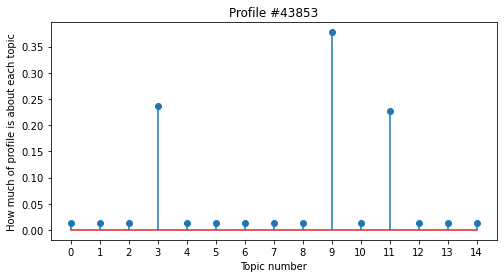

In [19]:
pid = 43853
visualize_profile(profile_topics, profile_id=pid)

## Section 5: Topic Quality
Let's see how good the topics we found are.

### Step 1: See if the topics are each about different things.
We want each topic to be about something different than the other topics. We can check this by comparing the words in each topic to the words in all the others. How to interpret:
- Each square shows how similar two topics are. Darker means more similar, and lighter means more different.
- The square in the very top left shows how similar topic 0 is to topic 0 (i.e. how similar it is to itself). 
- The square next to it in the top row shows how similar topic 0 is to topic 1, and so on. 
- For any two topics, you can see how similar they are by finding their numbers on the edges and seeing where they intersect.

<Figure size 432x288 with 0 Axes>

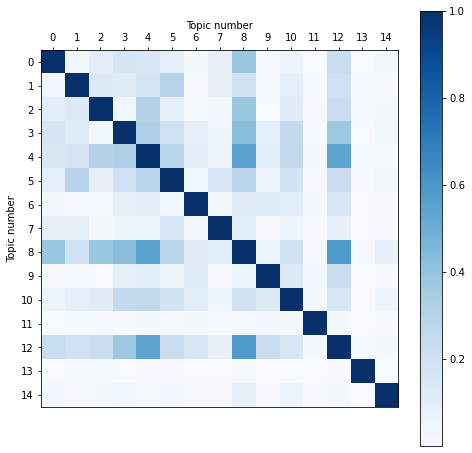

In [20]:
def plot_topics(components):
    sim = cosine_similarity(components)
    blue_matrix(sim, xl='Topic number', yl='Topic number')
    return

plot_topics(lda_topics)

### Step 2: See if different topics show up in different profiles
The point is to tell profiles apart based on what topics they're about, so we need to check whether the topics appear in different profiles.
- This shows us something that looks similar to the topic similarity we saw before, but this time:
    - We **don't** compare topics based on which words they use
    - We **do** compare topics based on how often they appear in the same profile as one another

<Figure size 432x288 with 0 Axes>

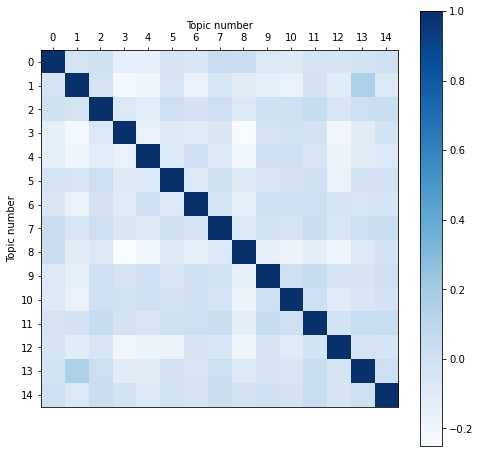

In [21]:
def topic_cooccurance(topics):
    co = pd.DataFrame(topics).corr()
    blue_matrix(co, xl='Topic number', yl='Topic number')

topic_cooccurance(profile_topics)

#### Note that the topics are mostly uncorrelated. 
- The cells in the figure above are mostly very light blue
- This doesn't mean that, for instance, topic 1 and 2 never show up in the same profile.
- It does mean, however, that seeing any particular topic doesn't mean we're especially likely to also see any other topic.

#### Reflect:
- Why is the diagonal line so dark? Write a sentence or two.

**Write your response here:**
....

## Section 6: Topic Popularity

#### Helper functions to visualize and compare topics
- Run this code and scroll down. The details of how it works aren't our focus right now.

In [22]:
def common_topics_bars(topics):
    popularity = pd.DataFrame(topics).mean()
    popularity = popularity.rename_axis('Topic')
    popularity = popularity.sort_values(ascending=False)
    popularity.plot.bar(title='Topic popularity')
    return

def rank_groups(data, trait, topic):
    groups = data[trait].value_counts().index.values
    result = {}
    
    for g in groups:
        result[g] = data[data[trait] == g][topic].mean()
    
    r = pd.DataFrame.from_dict(result, orient='index')
    r.columns = [topic]
    r = r.sort_values(by=topic, ascending=False)
    
    return r.round(3)

def top_topics(data, trait, value, n_top_topics=3, distinctive=False):
    topics = [col for col in data if col.startswith('topic_')]
    vals = {}
    means = {}
    if distinctive:
        for t in topics:
            means[t] = data[t].mean()
    else:
        for t in topics:
            means[t] = 1
    
    data = data[data[trait] == value]
    
    for t in topics:
        vals[t] = data[t].mean() / means[t]
    vals = pd.DataFrame.from_dict(vals, orient='index')    
    vals = vals.sort_values(by=0, ascending=False).head(n_top_topics)

    return list(vals.index.values)

### Overall most common topics

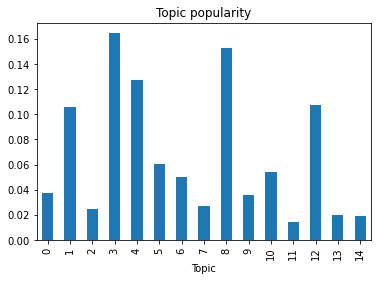

In [23]:
common_topics_bars(profile_topics)

### Who is a topic most popular with?

#### Step 1: Merge our information about topics with our information about people

In [24]:
topic_info = pd.DataFrame(profile_topics).add_prefix('topic_')
together = profiles.merge(topic_info, left_index=True, right_index=True)
together.head()

,age_group,age,body,alcohol_use,drug_use,edu,race_ethnicity,height_group,industry,kids,...,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14
0,20,22,overweight,yes,no,HS,multiple,over_6,other,no,...,0.000926,0.033606,0.000926,0.000926,0.000926,0.000926,0.015233,0.000926,0.000926,0.000926
1,30,35,average,yes,yes,unknown,White,under_6,other,no,...,0.001852,0.001852,0.001852,0.001852,0.001852,0.001852,0.001852,0.277766,0.001852,0.129308
2,30,38,thin,yes,yes,Grad_Pro,NaN,under_6,NaN,no,...,0.124901,0.000980,0.000980,0.000980,0.016809,0.000980,0.000980,0.000980,0.030590,0.000980
3,20,23,thin,yes,yes,HS,White,under_6,education,no,...,0.022222,0.022222,0.688889,0.022222,0.022222,0.022222,0.022222,0.022222,0.022222,0.022222
4,20,29,fit,yes,no,BA,multiple,under_6,creative,no,...,0.117195,0.003704,0.003704,0.003704,0.003704,0.003704,0.003704,0.460439,0.003704,0.003704


#### Step 2: See the groups that have the most text about a given topic
- The numbers here show how much of a profile, on average, is about a specific topic.

#### Play around with the code in the next few cells:
- Pick one of the traits we have data for. Here are the options (information we know about users from their profiles):
    - `age_group` categories: ['10', '20', '30', '40', '50']
    - `body` categories: ['average', 'fit', 'thin', 'overweight', 'unknown']
    - `alcohol_use` categories: ['yes', 'no']
    - `drug_use` categories: ['yes', 'no']
    - `edu` (highest degree completed) categories: ['`<HS`', 'HS', 'BA', 'Grad_Pro', 'unknown'] 
    - `race_ethnicity` categories: ['Asian', 'Black', 'Latinx', 'White', 'multiple', 'other']
    - `height_group` (whether someone is over or under six feet tall) categories: ['under_6', 'over_6']
    - `industry` (what field they work in) categories: ['STEM', 'business', 'education', 'creative', 'med_law', 'other'] 
    - `kids` (whether they have children) categories: ['yes', 'no']
    - `orientation` categories: ['straight', 'gay', 'bisexual']
    - `pets_likes` (what pets they like) categories: ['both', 'dogs', 'cats', 'neither']
    - `pets_has` (what pets they have) categories: ['both', 'dogs', 'cats', 'neither']
    - `pets_any` (whether they have pets or not) categories: ['yes', 'no']
    - `religion` categories: ['christianity', 'catholicism', 'judaism', 'buddhism', 'none', 'other'] 
    - `sex` categories: ['m', 'f']
    - `smoker` categories: ['yes', 'no']
    - `languages` categories: ['multiple', 'English_only'] 
- Change the topics and values in the code in the next few cells to explore how the trait you chose relates to the topics.
    
#### Short Answer:
- Write down which trait(s) you chose to look at, and what you learned about different groups of people from the topics they used. What topics do they have in common? What topics make them different? Does this make sense given the groups? Why or why not? Remember: we interpreted the topics above, so explain your findings in terms of content, not just topic numbers. Write 1-2 paragraphs.

In [25]:
rank_groups(together, trait='edu', topic='topic_5')

,topic_5
HS,0.063
BA,0.061
unknown,0.061
Grad_Pro,0.061
<HS,0.051


#### Step 3: See the topics that are most common for a given group
- This example shows most common topics for different education groups.
- You can change the arguments to compare different groups.

In [26]:
#show most popular topics for High School graduates
top_topics(data=together, trait='edu', value='HS', n_top_topics=3)

['topic_3', 'topic_8', 'topic_4']

In [27]:
#show most popular topics for High School graduates
top_topics(data=together, trait='edu', value='BA', n_top_topics=3)

['topic_3', 'topic_8', 'topic_4']

#### Step 4: See the topics that distinguish a group from other groups
- This example shows most distinctive topics for different education levels.
- You can change the arguments to compare different groups

In [28]:
top_topics(data=together, trait='edu', value='HS', n_top_topics=3, distinctive=True)

['topic_9', 'topic_5', 'topic_7']

In [29]:
top_topics(data=together, trait='edu', value='Grad_Pro', n_top_topics=3, distinctive=True)

['topic_13', 'topic_2', 'topic_0']

**Write your response here:**
....

# Section 7: NMF Topic Model
- NMF is an alternative to LDA
- NMF stands for Non-Negative Matrix Factorization. 

### Expand for more on how NMF works

- `Factoring` is something you may have done in math class before, for example:
    - $ 10 $ can be factored as $ 2 \times 5 $
    - $ x^2+3x+2 $ can be factored as $ (x+2)(x+1)$
- When we convert the text into numbers for the computer, it gets stored as something called a `matrix`.
    - The matrix is `non-negative` because we can't have negative numbers of words: all the word counts are zero or more.
- It is not important right now how exactly we find factors for these matrices, but if you're curious, you can learn more about it in a Linear Algebra class.
- It turns out that finding factors for text is a really good way of finding topics. This makes sense intuitively: factors are simple things we can combine to get the more complicated output, and topics are simple things people combine to write profiles.
- [Learn more](https://en.wikipedia.org/wiki/Non-Negative_matrix_factorization#Text_mining) about NMF.

### Step 1: Convert text to numbers the computer understands
- NMF takes "tf-idf vectors" as input. Tf-idf stands for "text frequency - inverse document frequency." 
    - Text frequency is the same as the count vectors we used for LDA above: how often does each word appear in the text?
    - Inverse document frequency means we divide ("inverse") by the number of documents the word is in. (If everyone uses the word, it isn't very helpful for figuring out what makes people different. So this measurement looks for words that are used a lot in some documents, and not at all in others.)

In [30]:
tfidf_vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')

print("Vectorizing text by TF-IDF...")
tfidf_text = tfidf_vectorizer.fit_transform(documents)

tmp = tfidf_text.get_shape()
print("Our transformed text has", tmp[0], "rows and", tmp[1], "columns.")

Vectorizing text by TF-IDF...
Our transformed text has 53396 rows and 1000 columns.


#### The features are mostly the same as count vectors, because they are just the common words in the text

In [31]:
tfidf_words = tfidf_vectorizer.get_feature_names()
print("The first few words (alphabetically) are:\n", tfidf_words[:20])

The first few words (alphabetically) are:
 ['10', '11', '12', '15', '20', '30', 'ability', 'able', 'abroad', 'absolutely', 'act', 'active', 'activities', 'activity', 'actually', 'add', 'admit', 'adventure', 'adventures', 'adventurous']


#### The values are different: the counts have been divided by the documents they show up in

In [32]:
n = 4

print('Profile text:\n', documents[n])
print('\nTF-IDF vector:')
show_vector(tfidf_text[n], words=tfidf_words)

Profile text:
 hey how's it going? currently vague on the profile i know, more to
come soon. looking to meet new folks outside of my circle of
friends. i'm pretty responsive on the reply tip, feel free to drop
a line. cheers.

TF-IDF vector:
free 	 0.25
feel 	 0.22
outside 	 0.26
folks 	 0.36
meet 	 0.2
soon 	 0.31
come 	 0.25
profile 	 0.26
currently 	 0.26
going 	 0.17
hey 	 0.3
pretty 	 0.19
friends 	 0.15
new 	 0.14
looking 	 0.16
line 	 0.33
know 	 0.17


### Step 2: Build a topic model using NMF

- NMF is faster than LDA and often works a little better for small documents like we have here.

In [33]:
model = NMF(n_components=ntopics, alpha=.1, l1_ratio=.5, init='nndsvd')

print('Performing NMF on vectors...')
nmf = model.fit(tfidf_text)
nmf_topics = nmf.components_

print('Done!')

Performing NMF on vectors...
Done!


### Step 3: Show our topics with the top words in each

In [34]:
display_topics(nmf_topics, tfidf_words, nshow)

Topic 0: enjoy music movies hiking watching playing cooking friends reading sports
Topic 1: years sf moved ve ago school lived year coast city
Topic 2: don know really people think want ll say ve way
Topic 3: new people meet things meeting trying try places friends learning
Topic 4: like things play stuff feel watch lot think people movies
Topic 5: im dont lol chill thats guy know person laid nice
Topic 6: love laugh travel outdoors family dance cook make music food
Topic 7: life live world share things believe happy family living important
Topic 8: san francisco city born raised moved living diego live native
Topic 9: bay area raised born native east grew moved living lived
Topic 10: going easy person guy pretty laid earth fun open try
Topic 11: just ask want know moved trying message wanna hang hey
Topic 12: time work spend hard friends working lot family free play
Topic 13: good humor sense food conversation pretty laugh company great friends
Topic 14: looking fun guy loving meet ni

### Step 4: Compare topics to each other
We can compare topics visually by plotting the similarity of each topic's chosen words to each other topic.

<Figure size 432x288 with 0 Axes>

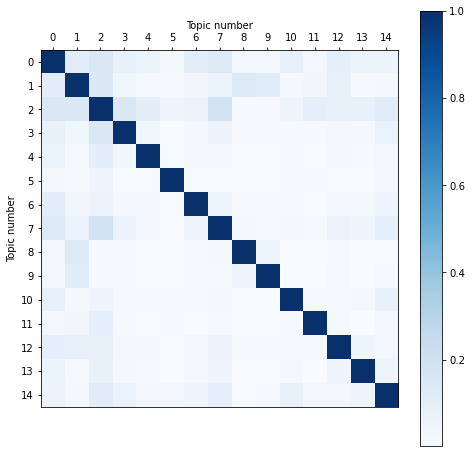

In [35]:
plot_topics(nmf_topics)

#### Examine the words that make two topics similar or different
We can also compare two topics to each other by looking at words that are common in both, or words that are common in one but not the other. Try changing topic_a and topic_b to different topic numbers.

In [36]:
topic_a = 1
topic_b = 8

compare_topic_words(nmf_topics, topic_a, topic_b, tfidf_words, n_words=nshow, how='overlap')
compare_topic_words(nmf_topics, topic_a, topic_b, tfidf_words, n_words=nshow, how='difference')
compare_topic_words(nmf_topics, topic_b, topic_a, tfidf_words, n_words=nshow, how='difference')

overlap between 1 and 8: moved originally grew recently born lived years living year city
difference between 1 and 8: played outside oakland middle 10 ny italy pretty mountains places
difference between 8 and 1: san francisco male nerdy relaxing hang friendly reality clubs nice


### Step 5: Interpret these topics
- This part is for you to do: code can't do it for you.
- Look at the list of important words for each topic, and think about these questions. (No writing required.)
    - What do the words have in common?
    - What could someone write that would use most of those words?
    - What does this topic seem to be about?
- Try to come up with a short, catchy name for each topic.
    - For example, if the words were "san francisco city moved living born years raised lived live", you might call it "places lived" because the topic seems to be about where people currently live (San Francisco) and where they were born / raised / moved from. 
- Try other numbers of topics.
    - If the topics seem repetitive, you might want to try looking for fewer topics.
    - If the topics seem confusing or vague, you might want to try looking for more topics (so that they can be more specific).

### Step 6: Compare the topics from LDA and NMF

#### Helper function to make a graph for us

In [37]:
def plot_confusion(x, y, x_label='', y_label='', sort=True):
    n = x.shape[0]
    corrs = cosine_similarity(x, y)
    topic_similarity = pd.DataFrame(corrs)
    new_order=None
    
    if sort:
        matches = []
        pairs = {}

        for i in range(n):
            for j in range(n):
                tmp = {}
                tmp['i'] = i
                tmp['j'] = j
                tmp['match'] = corrs[i][j]
                matches.append(tmp)

        matches = pd.DataFrame(matches).sort_values(by='match', ascending=False)

        for row in matches.iterrows():
            i = row[1]['i']
            j = row[1]['j']
            if i not in pairs.keys():
                if j not in pairs.values():
                    pairs[i] = row[1]['j']

        new_order = list(range(n))
        for k in pairs.keys():
            new_order[int(k)] = int(pairs[k])

        topic_similarity = topic_similarity[new_order]

    blue_matrix(topic_similarity, xl=x_label, yl=y_label,
                x_labels=new_order)
    return

#### See how similar the words in each topic from LDA are to the words in each topic from NMF
- The NMF topics are along the X axis and the LDA are along the Y axis.

<Figure size 432x288 with 0 Axes>

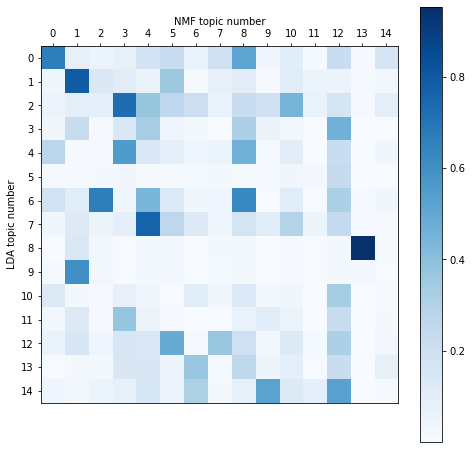

In [38]:
plot_confusion(x = nmf_topics, x_label='NMF topic number',
               y = lda_topics, y_label='LDA topic number',
               sort=False)

#### We can also sort the topics so that the most similar ones are aligned

<Figure size 432x288 with 0 Axes>

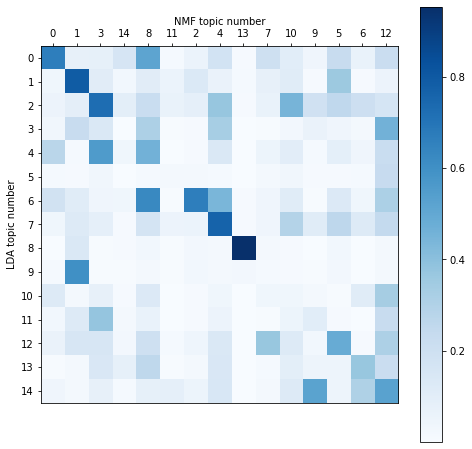

In [39]:
plot_confusion(x = nmf_topics, x_label='NMF topic number',
               y = lda_topics, y_label='LDA topic number',
               sort=True)

Look at the LDA and NMF topic words and the confusion matrix, and consider the following questions (no writing required):
- Do any of the topics seem to be the same in both models?
- Are some topics in one model but not the other?
- Do the topics you get from one of the models make more sense than the ones you get from the other?


## Section 8: What We Learned
- Two statistical methods for topic modeling
    - LDA
    - NMF
- Two ways to represent text as numbers
    - TF / count vectors (counts of how often each word is used)
    - TF-IDF vectors (counts of how often each word is used, divided by the number of documents they're used in)
- How to think about and interpret the topics our models find
- How to compare and relate different topics
- Different ways to see the distribution of topics in profiles
- Which topics are most popular with social categories of people
- Which social categories of people discuss a topic most

#### Reflect
- How is what we learned in this lab, using topic modeling, different from what we learned in the last lab, using just word frequencies? How is it similar? Write a paragraph explaining. 

**Write your response here:**
....